Instacart operates a grocery delivery and pick-up service across the US and parts of Canada. In 2017, Instacart released an open sourced dataset that comprises 3 millon orders. By exploring this dataset, we can learn about when customers order, what they order, what they re-order, and how often they order. The purpose of this project is to determine whether we can build machine learning models to accurately predict which products Instacart customers re-order. To do so, I will start by exploring the data in detail. I will then fit six different supervised models (logistic regression, KNN, decision tree, random forest, SVC, and gradient boosting models) to determine whether the models can be used to accurately predict future re-orders. I use selectKbest (to find the most important features) and fit these six models, and then apply PCA and use the components to again fit the six supervised models.   

I also apply unsupervised learning techniques to the data, aiming to explore whether the data clusters in meaningful and interesting ways. Finally, I build an artifical neutral network to determine if deep learning techniques are useful for this datasest. The data was accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on May 14, 2020.

## Data Exploration

### Imports

In [1]:
pip install tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 40kB/s 
     |████████████████████████████████| 501kB 40.1MB/s 
     |████████████████████████████████| 4.3MB 31.7MB/s 


In [1]:
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC 
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn import svm, datasets
from sklearn.mixture import GaussianMixture
from scipy.stats.mstats import winsorize
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import io
%matplotlib inline

## Data Exploration

There are six different files included with this Instacart data. The **orders** file, contains data about each order (the person who ordered [id number], when the order was purchased [e.g., day of week, hour of day], etc.). The rows contain the individual orders, and each user has ordered between 4 and 100 times. The **order_products_prior** and **order_products_train** files contain data on the products that were purchased in each order. The former contains data on the previous (most recent) orders for all customers, while the latter contains data on last orders for a subset of customers. I did not use the **order_products_train** file in this project for two reasons. First, I faced computational limitations; second, this dataset was originally used for a competition wherein the contestants needed to utilize this separate file to predict exactly which products were in each basket (which is not the goal of the current project). The **aisles** file provides data on the aisle names, while the **departments** file contains information on the various departments in the stores. Finally, the **products** file provides data on the product names, product ids, and the aisles/departments where the product is located. I will load each file and assign them to dataframes. Then, I will begin the exploration by examining each dataframe individually. 

In [2]:
#load data and assign to dataframes
aisle_df = pd.read_csv(
    r'C:\Users\Lowe\Documents\Thinkful\Datasets\Final Capstone Data\aisles.csv')
departments_df = pd.read_csv(
    r'C:\Users\Lowe\Documents\Thinkful\Datasets\Final Capstone Data\departments.csv')
order_products_prior_df = pd.read_csv(
    r'C:\Users\Lowe\Documents\Thinkful\Datasets\Final Capstone Data\order_products__prior.csv')
orders_df = pd.read_csv(
    r'C:\Users\Lowe\Documents\Thinkful\Datasets\Final Capstone Data\orders.csv')
products_df = pd.read_csv(
    r'C:\Users\Lowe\Documents\Thinkful\Datasets\Final Capstone Data\products.csv')

### Orders

Let's explore the **orders** dataframe, which provides detailed information on each order. 

In [0]:
print("Number of rows in the dataset : ",len(orders_df))

Number of rows in the dataset :  1048575


In [0]:
orders_df.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


As the above table displays, this dataframe contains information on the order id, user id, order number, the day of the week that the order was placed, the hour of the day that the order was placed, how many days have passed since the last order, and which file the order was assigned to (prior, test, or train). This variable (eval_set) is not useful for the present project for reasons explained above. An important distinction is between order_id and order_number. Order_id is used to identify the specific order (think of this as similar to a confirmation number). Order_number, on the other hand, measures how many times a particular user has ordered from Instacart (from 4 to 100 times).

Let's check to see whether there are any missing values.

In [0]:
#get missing values
orders_df.isnull().sum()/orders_df.isnull().count().sort_values(ascending=True)

order_id                  0.000000
user_id                   0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    0.060177
dtype: float64

The missing values comprise 6.1% of the rows for the days_since_prior_order variable. No other variable contains missing values. I'll impute the mean for the missing values and check to make sure there were no substantial changes.

In [0]:
print("Mean for days_since_prior_order before imputation : ",orders_df['days_since_prior_order'].mean())

Mean for days_since_prior_order before imputation :  11.102505898170932


In [3]:
#impute mean for missing values
orders_df["days_since_prior_order"] = orders_df["days_since_prior_order"].fillna(orders_df["days_since_prior_order"].mean())

In [0]:
print("Mean for days_since_prior_order after imputation : ",orders_df['days_since_prior_order'].mean())

Mean for days_since_prior_order after imputation :  11.102505898167335


The difference in means before and after imputation is negligible. It is safe to move forward after imputing the mean for missing values. Let's see how many unique customers there are in the dataset.

In [0]:
print("Number of unique customers in the dataset : ",len(set(orders_df.user_id)))

Number of unique customers in the dataset :  63100


There are 63,100 users in total. Let's check out the time of day and day of week that people place orders.

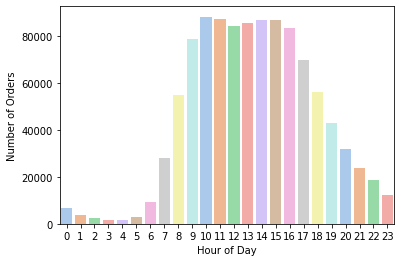

In [0]:
ax = sns.countplot(data=orders_df, x='order_hour_of_day', palette='pastel')
ax.set(xlabel='Hour of Day', ylabel='Number of Orders')
plt.show()

Most people order in the middle of the day, between 8am and 6pm. This makes sense since most people are likely not ordering groceries in the middle of the night.

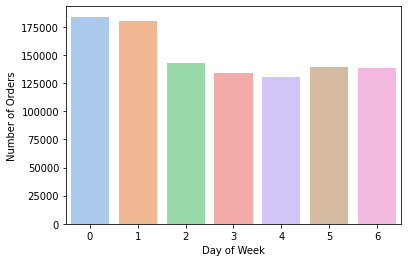

In [0]:
ax = sns.countplot(data=orders_df, x='order_dow', palette='pastel' )
ax.set(xlabel='Day of Week', ylabel='Number of Orders')
plt.show()

The above bar plot illustrates that the order count is highest early in the week, though there is not a huge variation in day of the week by number of orders placed.

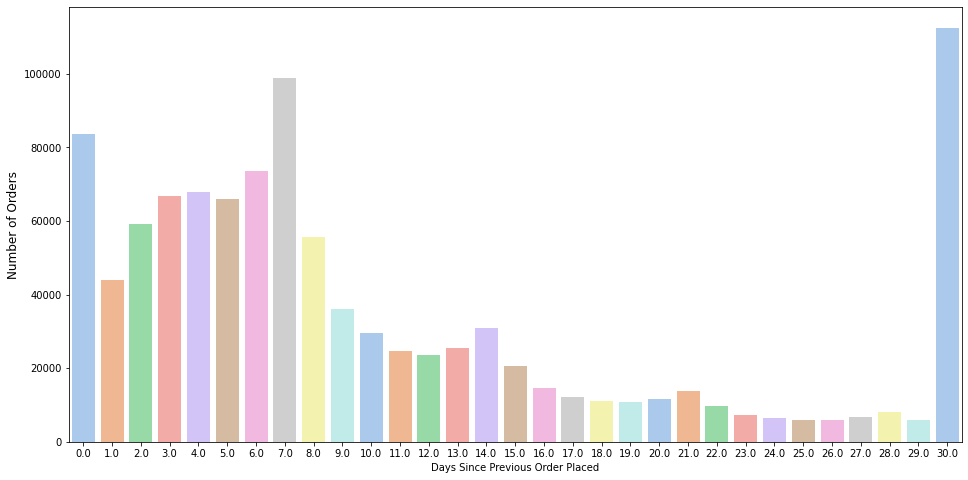

In [0]:
a = orders_df.groupby('order_id')['days_since_prior_order'].aggregate('sum').reset_index()
a = a.days_since_prior_order.value_counts()
plt.subplots(figsize=(16, 8))
sns.barplot(a.index,a.values,palette='pastel')
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Days Since Previous Order Placed')
plt.show()

The above barplot illustrates that the data is skewed to the left, indicating that most customers re-order within two weeks or so. There is a very large number of customers (over 100,000) who have not re-ordered in the last 30 days. I suspect that these customers either only use Instacart infrequently or do not plan to use the service again at all.

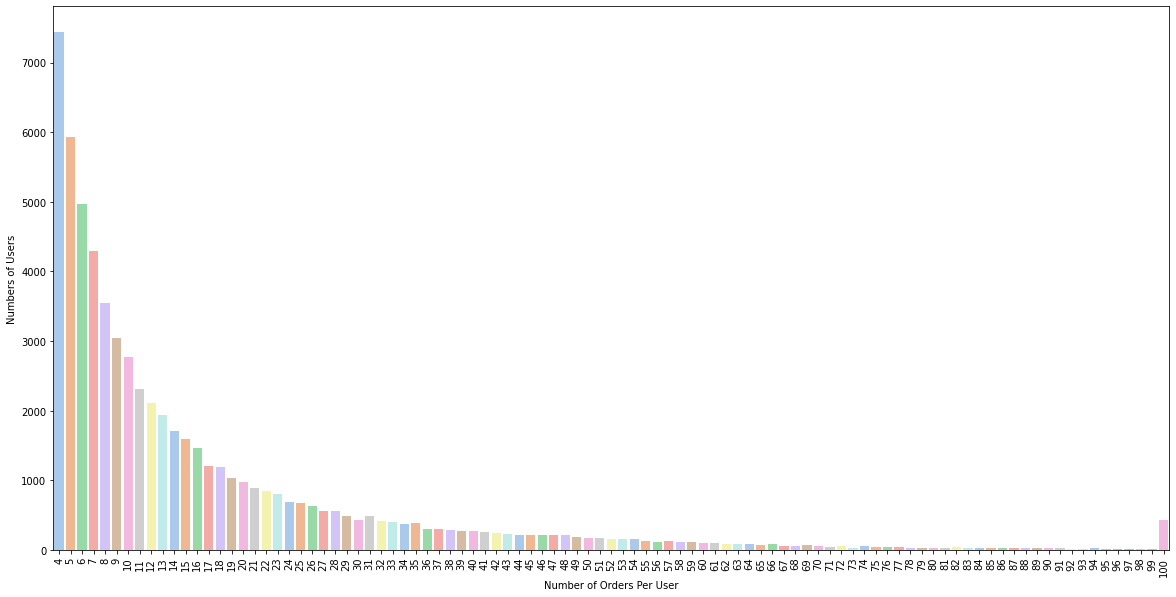

In [0]:
b = orders_df.groupby('user_id')['order_id'].apply(lambda x: len(x.unique())).reset_index()
b = b.groupby('order_id').aggregate('count')
plt.subplots(figsize=(20, 10))
sns.barplot(b.index, b.user_id, palette='pastel')
plt.ylabel('Numbers of Users')
plt.xlabel('Number of Orders Per User')
plt.xticks(rotation='vertical')
plt.show()

The above graphic illustrates the number of users per customer. Each customer has ordered at least 4 times but no more than 100 times. The distribution is heavily skewed to the left, indicating that most customers have ordered fewer than 20 times or so. 

Let's now explore the **order_products_prior** dataframe, which contains information on all previous orders.

In [0]:
print("Number of ordered products : ",len(order_products_prior_df))

Number of ordered products :  1048575


In [0]:
#look at first 10 rows
order_products_prior_df.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


The above table shows that this dataframe contains information on order_id, product_id,  add_to_cart_order, and reordered. Let's start by exploring whether there are missing values.

In [0]:
#get missing values
order_products_prior_df.isnull().sum()/order_products_prior_df.isnull().count().sort_values(ascending=True)

order_id             0.0
product_id           0.0
add_to_cart_order    0.0
reordered            0.0
dtype: float64

Luckily, there are no missing values in this dataframe. Let's check out the breakdown for the reordered variable.

In [0]:
#get value counts
order_products_prior_df['reordered'].value_counts()

1    619141
0    429434
Name: reordered, dtype: int64

In [0]:
#get percentage of reordered
print("The percentage of re-ordered products is ", order_products_prior_df['reordered'].sum() / order_products_prior_df.shape[0])

The percentage of re-ordered products is  0.5904594330400782


Text(0, 0.5, 'Value Counts')

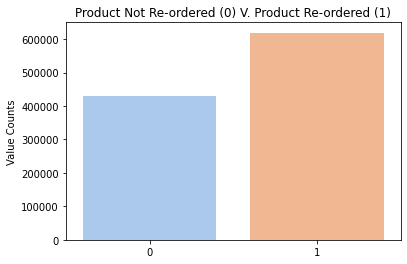

In [0]:
#plot value counts
sns.countplot(order_products_prior_df['reordered'], palette='pastel')
plt.title('Product Not Re-ordered (0) V. Product Re-ordered (1)')
plt.xlabel('')
plt.ylabel('Value Counts')

More products are reordered in comparison to products that are not re-ordered. Let's check out how many products people typically order from Instacart.

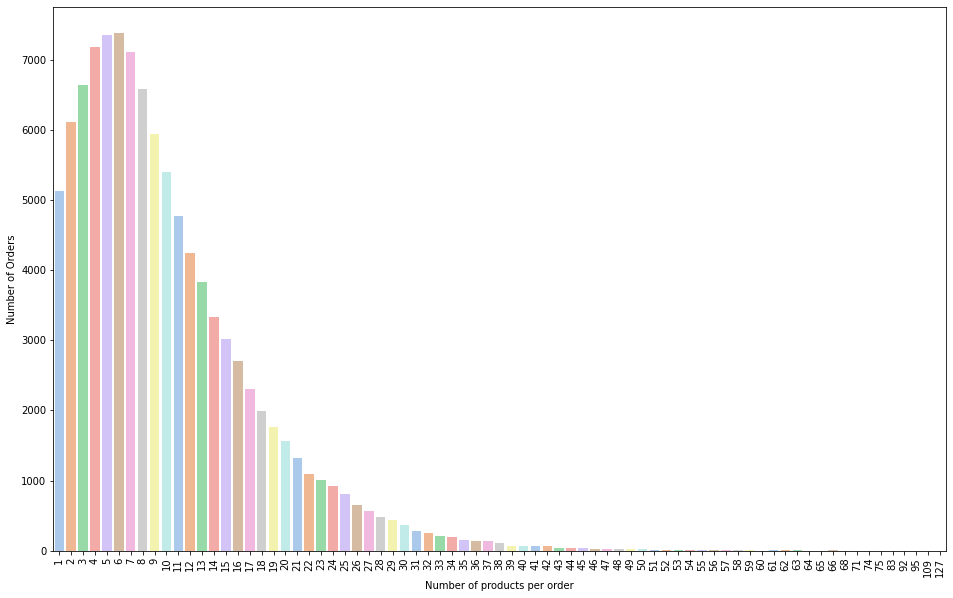

In [0]:
#get value counts
d = order_products_prior_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
d = d.add_to_cart_order.value_counts()

#plot value counts
plt.subplots(figsize=(16, 10))
plt.xticks(rotation='vertical')
sns.barplot(d.index, d.values, palette='pastel')

plt.ylabel('Number of Orders')
plt.xlabel('Number of products per order')
plt.show()

I want to merge the **products, orders**, and **orders_products_prior_df** dataframes so that I can explore which products are most often re-ordered. This is an important step because the **order_products_prior_df** only contains the product ids, which is not very meaningful. Merging all three dataframes will combine all order and all product information.

In [4]:
#merge dataframes
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


In [5]:
#merge dataframes
orders_products_df = pd.merge(orders_df, order_products_prior_df, on = 'order_id', how='inner')
orders_products_df.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,94891,4,prior,4,5,13,15.0,22199,1,0,Extra-Dry Cava,134,5
1,94891,4,prior,4,5,13,15.0,25146,2,0,Original Orange Juice,31,7


Now that I have the product name matched with product id, let's explore which products are most often ordered.

In [0]:
e = order_products_prior_df['product_name'].value_counts().reset_index()
e.columns = ['Product', 'Value Count']
e.head(15)

,Product,Value Count
0,Banana,15450
1,Bag of Organic Bananas,12409
2,Organic Strawberries,8528
3,Organic Baby Spinach,7852
4,Organic Hass Avocado,6857
5,Organic Avocado,5646
6,Large Lemon,4928
7,Strawberries,4587
8,Limes,4526
9,Organic Raspberries,4420


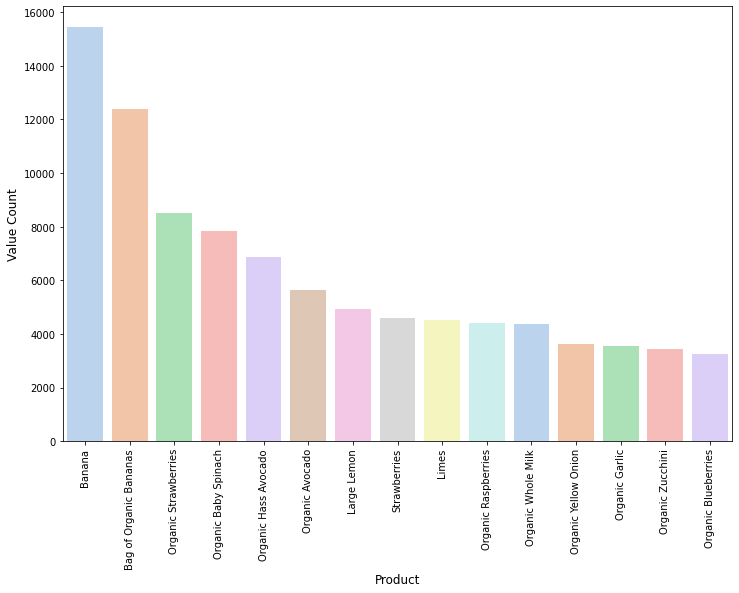

In [0]:
f = order_products_prior_df['product_name'].value_counts().head(15)
plt.figure(figsize=(12,8))
sns.barplot(f.index, f.values, alpha=0.8, palette='pastel')
plt.ylabel('Value Count', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()


The most ordered products from Instacart are nearly all fruits and vegetables. Interestingly, there are many organic products among the most popular orders.

Now, I want to merge the aisles and departments dataframes with this orders/products dataframe to explore the order breakdowns by aisle and department.

In [6]:
#merge dataframes
orders_products_df = pd.merge(orders_products_df, aisle_df, on = 'aisle_id', how='inner')
orders_products_df = pd.merge(orders_products_df, departments_df, on = 'department_id', how='inner')
orders_products_df.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,94891,4,prior,4,5,13,15.0,22199,1,0,Extra-Dry Cava,134,5,specialty wines champagnes,alcohol
1,103434,1362,prior,3,3,13,30.0,46725,18,0,"Champagne, Extra Dry, Sparkling California",134,5,specialty wines champagnes,alcohol


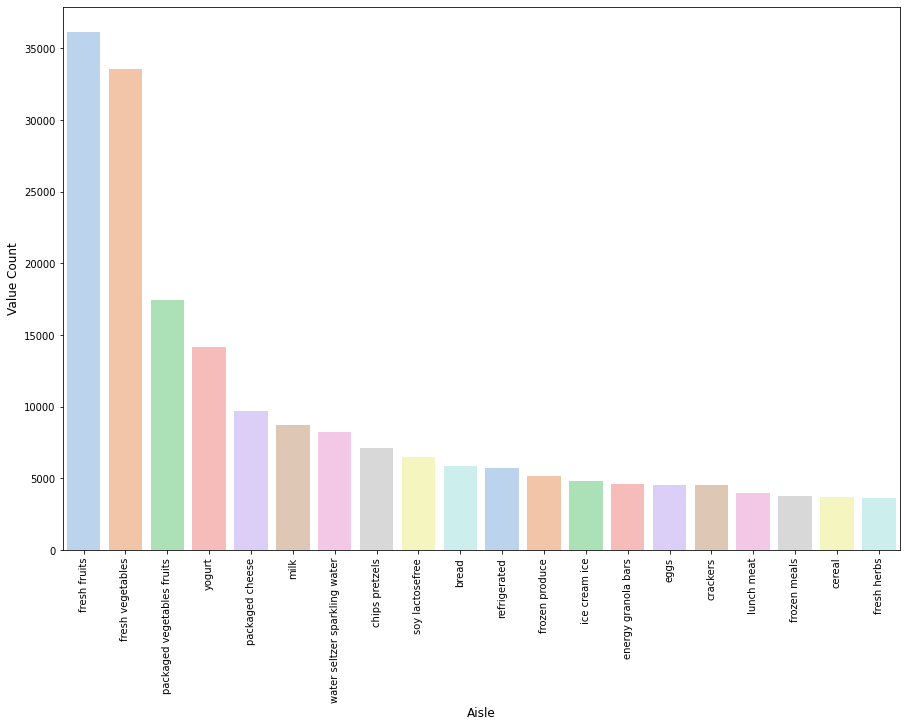

In [0]:
x = orders_products_df['aisle'].value_counts().head(20)
plt.figure(figsize=(15,10))
sns.barplot(x.index, x.values, alpha=0.8, palette='pastel')
plt.ylabel('Value Count', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The fresh fruit, fresh vegetable, packaged vegetables/fruits, yogurt, packaged cheese, and milk aisles are shopped most often. This makes sense because product and fresh products need to be replaced more often, unlike pantry products that last much longer.

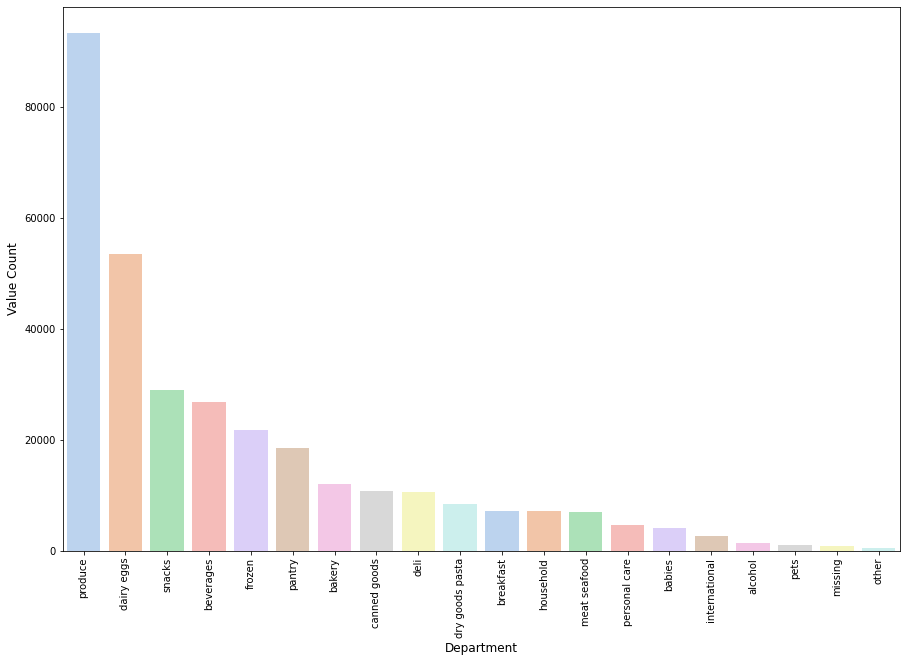

In [0]:
z = orders_products_df['department'].value_counts().head(20)
plt.figure(figsize=(15,10))
sns.barplot(z.index, z.values, alpha=0.8, palette='pastel')
plt.ylabel('Value Count', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The product, dairy/eggs, snacks, beverages, and frozen departments are shopped most often. Let's create a WordCloud of the product names to further explore the most commonly re-ordered products.

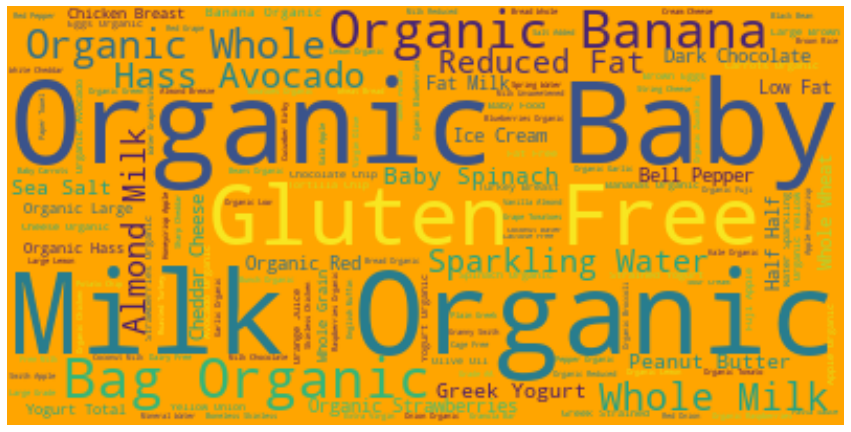

In [14]:
from wordcloud import WordCloud
# Generate a word cloud image
wordcloud = WordCloud(background_color="orange").generate(" ".join(orders_products_df["product_name"]))
plt.figure(figsize=(15,10))
# Display the image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The WordCloud is interesting and informative, and it also illustrates that fresh food (milk, avocados, yogurt, bananas, etc.) are popular. The WordCloud also makes clear that organic products are popular.

Now that all dataframes are merged and that we have a good understanding of the data, I'll check to see whether there are outliers.

In [0]:
#create list of the numeric columns to check outliers
numeric_columns = orders_products_df.select_dtypes(['int64', 'float64']).columns
numeric_columns = numeric_columns.drop('order_id')
numeric_columns = numeric_columns.drop('user_id')

#get ouliers for numeric columns
for col in numeric_columns:
    q75, q25 = np.percentile(orders_products_df[col], [75 ,25])
    iqr = q75 - q25


    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    print("The number of outliers for {} is: {}. This is {} percent of the column.".format(col, len((np.where((orders_products_df[col] > max_val) 
                      | (orders_products_df[col] < min_val))[0])), len((np.where((orders_products_df[col] > max_val) | 
                                                    (orders_products_df[col] < min_val))[0]))*100/1987))

The number of outliers for order_number is: 17648. This is 888.1731253145446 percent of the column.
The number of outliers for order_dow is: 0. This is 0.0 percent of the column.
The number of outliers for order_hour_of_day is: 1922. This is 96.72873678912934 percent of the column.
The number of outliers for days_since_prior_order is: 33744. This is 1698.238550578762 percent of the column.
The number of outliers for product_id is: 0. This is 0.0 percent of the column.
The number of outliers for add_to_cart_order is: 13103. This is 659.4363361852038 percent of the column.
The number of outliers for reordered is: 0. This is 0.0 percent of the column.
The number of outliers for aisle_id is: 0. This is 0.0 percent of the column.
The number of outliers for department_id is: 0. This is 0.0 percent of the column.


Text(0.5, 1.0, 'Add to Cart--Order')

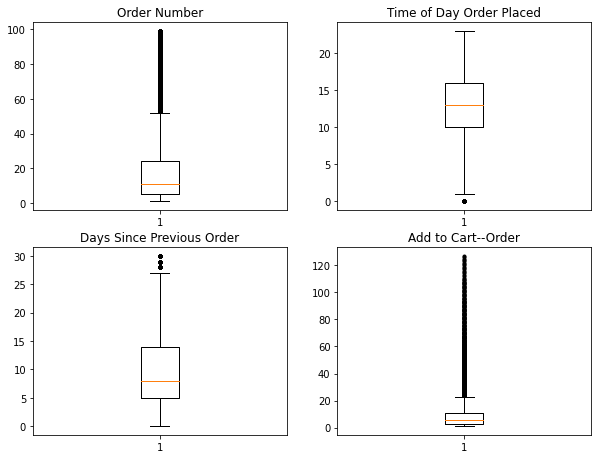

In [0]:
#box plots to observe outliers
fig = plt.figure(figsize=(10,20))

plt.subplot(5, 2, 1)
plt.boxplot(orders_products_df["order_number"], sym='k.')
plt.title("Order Number")

plt.subplot(5, 2, 2)
plt.boxplot(orders_products_df["order_hour_of_day"], sym='k.')
plt.title("Time of Day Order Placed")

plt.subplot(5, 2, 3)
plt.boxplot(orders_products_df["days_since_prior_order"], sym='k.')
plt.title("Days Since Previous Order")

plt.subplot(5, 2, 4)
plt.boxplot(orders_products_df["add_to_cart_order"], sym='k.')
plt.title("Add to Cart--Order")


The bloxplots illustrate that there are outliers for a few variables. However, I am deciding to keep the outliers (and not winsorize or log-transform them) because ultimately I am interested in all product re-orders. In certain cases, it is necessary to remove outliers, but I want to keep them for this project. A future project could look specifically at recent orders, excluding outliers.

Now, I want to begin the process of building models that will hopefully be useful for future product re-order predictions. I'll first check to make sure there are no missing values now that we merged the aisles and departments with the main dataframes.

In [0]:
orders_products_df.isnull().sum()/orders_products_df.isnull().count().sort_values(ascending=True)

order_id                  0.0
user_id                   0.0
eval_set                  0.0
order_number              0.0
order_dow                 0.0
order_hour_of_day         0.0
days_since_prior_order    0.0
product_id                0.0
add_to_cart_order         0.0
reordered                 0.0
product_name              0.0
aisle_id                  0.0
department_id             0.0
aisle                     0.0
department                0.0
dtype: float64

Luckily, there are no missing values to address. Let's check out each variable's datatype.

In [0]:
orders_products_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320541 entries, 0 to 320540
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                320541 non-null  int64  
 1   user_id                 320541 non-null  int64  
 2   eval_set                320541 non-null  object 
 3   order_number            320541 non-null  int64  
 4   order_dow               320541 non-null  int64  
 5   order_hour_of_day       320541 non-null  int64  
 6   days_since_prior_order  320541 non-null  float64
 7   product_id              320541 non-null  int64  
 8   add_to_cart_order       320541 non-null  int64  
 9   reordered               320541 non-null  int64  
 10  product_name            320541 non-null  object 
 11  aisle_id                320541 non-null  int64  
 12  department_id           320541 non-null  int64  
 13  aisle                   320541 non-null  object 
 14  department          

Each variable has the expected datatype. 

In [0]:
print("Number of unique customers in the dataset : ",len(set(orders_products_df.user_id)))

Number of unique customers in the dataset :  21099


In [0]:
print("Number of unique orders in the dataset : ",len(set(orders_products_df.order_id)))

Number of unique orders in the dataset :  31777


In [0]:
print("Number of ordered products in the dataset : ",len(orders_products_df))

Number of ordered products in the dataset :  320541


There are fewer rows in the dataframe after merging because we only kept the rows where the order_id matched. Let's make sure the target variable (reordered) is not imbalanced.

In [0]:
#see how reordered is distributed
orders_products_df['reordered'].value_counts()

1    189606
0    130935
Name: reordered, dtype: int64

Text(0, 0.5, 'Number of Observations')

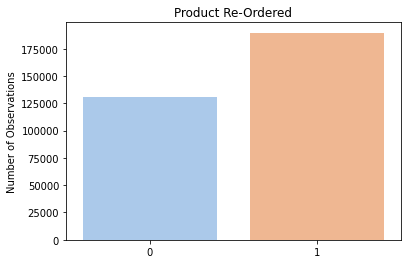

In [0]:
#plot value counts
sns.countplot(orders_products_df['reordered'], palette='pastel')
plt.title('Product Re-Ordered')
plt.xlabel('')
plt.ylabel('Number of Observations')

The dataset is not horribly imbalanced, but this still needs to be addressed since there were 189606 products reordered and 130935 products not reordered. I will upsample to fix this imbalance issue.

In [7]:
# Separate majority and minority classes
df_majority = orders_products_df[orders_products_df.reordered==1]
df_minority = orders_products_df[orders_products_df.reordered==0]
 
# Upsample minority class to a similar size as majority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples=189000,    
                                 random_state=123)
# Combine upsampled minority class with majority class
df_resampled = pd.concat([df_minority_upsampled, df_majority])
 
# Display new class counts
df_resampled.reordered.value_counts()

1    189606
0    189000
Name: reordered, dtype: int64

The dataset is no longer imbalanced, with close to 190,000 observations for each class.

In [0]:
#get correlation matrix
df_resampled.corr()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
order_id,1.000000,-0.001046,-0.007481,-0.002406,0.000746,0.005911,0.001304,0.011477,0.000258,0.001468,-0.001308
user_id,-0.001046,1.000000,-0.011942,-0.004057,-0.004958,-0.006177,-0.001726,-0.000875,-0.006793,0.000364,0.001315
order_number,-0.007481,-0.011942,1.000000,0.020250,-0.033771,-0.343468,-0.001290,-0.012770,0.314209,0.000719,0.005241
order_dow,-0.002406,-0.004057,0.020250,1.000000,0.012291,-0.025899,-0.001455,0.000243,-0.007726,-0.003559,0.003249
order_hour_of_day,0.000746,-0.004958,-0.033771,0.012291,1.000000,0.005288,0.002809,-0.020652,-0.030719,0.001265,-0.012785
days_since_prior_order,0.005911,-0.006177,-0.343468,-0.025899,0.005288,1.000000,0.001020,0.055571,-0.127708,0.004875,-0.000615
product_id,0.001304,-0.001726,-0.001290,-0.001455,0.002809,0.001020,1.000000,0.004646,0.007771,0.003292,-0.028897
add_to_cart_order,0.011477,-0.000875,-0.012770,0.000243,-0.020652,0.055571,0.004646,1.000000,-0.141460,0.005434,0.028243
reordered,0.000258,-0.006793,0.314209,-0.007726,-0.030719,-0.127708,0.007771,-0.141460,1.000000,0.003202,-0.041531
aisle_id,0.001468,0.000364,0.000719,-0.003559,0.001265,0.004875,0.003292,0.005434,0.003202,1.000000,0.052036


The correlation matrix indicates that the re-ordered variable is most correlated with order_number, days_since_prior_order, and add_to_cart_order. The remaining variables are hardly correlated with the target variable, and I expect that the feature selection via selectKbest will demonstrate this.

In [0]:
#get descriptive statistics
df_resampled.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
count,261835.000000,261835.000000,261835.000000,261835.000000,261835.000000,261835.000000,261835.000000,261835.000000,261835.000000,261835.000000,261835.000000
mean,55744.803262,31422.205122,16.256918,2.743785,13.461184,11.257375,25533.572853,8.530040,0.499933,71.109038,9.994672
std,32026.598902,18169.335008,17.127147,2.088527,4.209609,8.478704,14104.996843,7.400046,0.500001,38.217328,6.276701
min,6.000000,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,28002.000000,15733.000000,4.000000,1.000000,10.000000,5.000000,13431.000000,3.000000,0.000000,31.000000,4.000000
50%,55790.000000,31310.000000,10.000000,3.000000,13.000000,9.000000,25157.000000,7.000000,0.000000,83.000000,9.000000
75%,83669.000000,47109.000000,22.000000,5.000000,16.000000,14.000000,37841.000000,12.000000,1.000000,107.000000,16.000000
max,110719.000000,63098.000000,99.000000,6.000000,23.000000,30.000000,49688.000000,127.000000,1.000000,134.000000,21.000000


To build models that will predict whether or not a product is ordered, I need to first split the dataframe into training and test sets. I can drop the object variables product_name, aisle_name, department_name because they match the numeric variables product_id, aisle_id, and department_id. I will also drop the eval_set column because it is not relevant to this project. 

In [36]:
#create X and Y
X = df_resampled[['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id', 'add_to_cart_order', 'aisle_id', 'department_id']]
Y = df_resampled['reordered']

#create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

## Supervised Learning Models 

### SelectKBest

Before I fit the various supervised learning models, I will use SelectKBest to find the 8 best features (80% of features). I will use these selectKbest chosen features and fit 6 supervised learning models. Then, I will apply PCA and will use the PCA components in the same 6 supervised models and compare the two techniques. I'll use grid search with each model to choose the best parameters.

In [0]:
#selectKbest to choose 8 most important features (80% of features)
best_features = SelectKBest(score_func=f_classif, k=8)
fit = best_features.fit(X,Y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)


# concatenate 
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature Name','Score'] 
print(feature_scores.nlargest(8,'Score'))

             Feature Name         Score
2            order_number  41466.857331
7       add_to_cart_order   7738.057170
5  days_since_prior_order   6287.577196
9           department_id    651.887916
4       order_hour_of_day    354.862161
6              product_id     23.264127
3               order_dow     22.812340
1                 user_id     17.762917


SelectKbest determined the following features to be the most important: order_number, add_to_cart_order, days_since_prior_order, department_id, order_hour_of_day, product_id, order_dow, user_id. This was what I expected based on the correlation matrix. I will update X using only these 8 chosen features and then fit 6 different supervised models.

In [0]:
#update X
X = df_resampled[['user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id', 'add_to_cart_order', 'department_id']]

#create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

### Logistic Regression with selectKbest features

A logistic regression is a type of linear classifier. This model can be useful when the data is linearly separable. I expect that this data may not be linearly separable. Training/testing the model and printing a classification report will tell me whether or not a logistic regression is a good fit to the data. 

In [0]:
#fit and train a logistic regression
lrm = LogisticRegression()
#grid search to choose best parameters
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_lrm_acc = GridSearchCV(lrm, param_grid = grid_values,scoring = 'recall')
grid_lrm_acc.fit(X_train, y_train)

#Predict values based on new parameters
y_pred = grid_lrm_acc.predict(X_test)

In [0]:
#evaluate model
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('AUC Score : ' + str(roc_auc_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Re-order', 'Did Re-order'])
print(report)
cv_scores = cross_val_score(grid_lrm_acc, X_train, y_train, cv = 5)
print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
 
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.6689205250785769
Precision Score : 0.7068026989145669
Recall Score : 0.5742736830954209
F1 Score : 0.6336830415850844
AUC Score : 0.6686662254214824
                  precision    recall  f1-score   support

Did Not Re-order       0.64      0.76      0.70     37963
    Did Re-order       0.71      0.57      0.63     37759

       micro avg       0.67      0.67      0.67     75722
       macro avg       0.67      0.67      0.67     75722
    weighted avg       0.67      0.67      0.67     75722

Accuracy scores for the 5 folds:  [0.57685216 0.57201185 0.57305147 0.57318318 0.57456617]
Mean cross validation score: 0.574
Confusion Matrix : 
[[28968  8995]
 [16075 21684]]


As expected, the logistic regression (trained with the selectKbest chosen features) did not perform too well. Even though I used grid search to find the best parameters, the accuracy was still only 67%, with the mean cross validation score being only 57%. The confusion matrix also illustrates that a logistic regression is not a good fit for the data, with 16,075 false negatives and 8,995 false positives.

### KNN with selectKbest

KNN (K Nearest Neighbors) is a **non-linear** classifier and it looks for similarities between data points. This algorithm compares each observation (or data point) to its closest (nearest) k neighbors. k is the number of neighbors set, which is determined by the data scientist. A KNN trained with k = 3 neighbors will compare an unknown observation to the 3 observations closest to it. The algorithm assigns the datapoint to a specific class based on which class is most common among the k neighbors. I'll train and test a KNN model, using grid search to determine which k is best.  

In [0]:
knn = KNeighborsClassifier()
#dictionary with values I want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
#fit model
knn_gscv.fit(X_train, y_train)

#Predict values 
y_pred = knn_gscv.predict(X_test)

In [0]:
#evaluate model
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('AUC Score : ' + str(roc_auc_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Re-order', 'Did Re-order'])
print(report)
cv_scores = cross_val_score(knn_gscv, X_train, y_train, cv = 5)
print('Accuracy scores for the 5 folds: ', cv_scores)
print('AUC Score : ' + str(roc_auc_score(y_test,y_pred)))
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
 

print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.7455164945458387
Precision Score : 0.7807233306003462
Recall Score : 0.6808972695251463
F1 Score : 0.727401329749611
AUC Score : 0.7453428738901448
                  precision    recall  f1-score   support

Did Not Re-order       0.72      0.81      0.76     37963
    Did Re-order       0.78      0.68      0.73     37759

       micro avg       0.75      0.75      0.75     75722
       macro avg       0.75      0.75      0.74     75722
    weighted avg       0.75      0.75      0.74     75722

Accuracy scores for the 5 folds:  [0.70875565 0.71034039 0.71275753 0.71135433 0.70891112]
AUC Score : 0.7453428738901448
Mean cross validation score: 0.710
Confusion Matrix : 
[[30742  7221]
 [12049 25710]]


KNN (trained with the features chosen by selectKbest) performed better than the logistic regression; for instance, the accuracy score for the KNN trained model is 75% (in comparison to 67% with the LR). This suggests that the data is likely not linearly separable and that instead an observation can be assigned to a class (re-ordered or not re-ordered) based on similarity to datapoints near to it. This KNN model had fewer false negatives (12,049) and false positives (7,221) than the LR, but there is certainly room for improvement.

### Decision Tree with selectKbest

Decision trees are another type of non-linear classifer. This algorithm assigns datapoints to certain classes (in this case, re-ordered or not re-ordered) by splitting the data based on a specific differentiator in the data. This process is repeated until each observation is assigned to a class (or 'leaf' in the decision tree). Decision trees examine the observations to determine where to split the data, and they attempt to make efficient decisions at each split, but this algorithm is often subject to overfitting. Let's train and test X with a decision tree and check its peformance, using grid search to choose the best parameters.

In [0]:
#fit the tree using the best parameters (determined by gridsearch)
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)
clf.fit(X_train, y_train)
#Predict values 
y_pred = clf.predict(X_test)

In [0]:
#evaluate model
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('AUC Score : ' + str(roc_auc_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Re-order', 'Did Re-order'])
print(report)
cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)

print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))

print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.7998864266659623
Precision Score : 0.8417694726656991
Recall Score : 0.7372811779972986
F1 Score : 0.7860682469540172
AUC Score : 0.7997182172155973
                  precision    recall  f1-score   support

Did Not Re-order       0.77      0.86      0.81     37963
    Did Re-order       0.84      0.74      0.79     37759

       micro avg       0.80      0.80      0.80     75722
       macro avg       0.80      0.80      0.80     75722
    weighted avg       0.80      0.80      0.80     75722

Accuracy scores for the 5 folds:  [0.77638747 0.77757602 0.77743661 0.77672676 0.77609945]
Mean cross validation score: 0.777
Confusion Matrix : 
[[32730  5233]
 [ 9920 27839]]


The classification report indicates that the decision tree we trained was 80% accurate. It does not seem to be overfit, as the accuracy scores for each of the 5 folds are similar. This algorithm satisfactorily made decisions as to where to split the data and which decision to make at each node. An 80% accuracy rate is not perfect, but this tree's performance suggests that the data can successfully be split at certain steps to make decent predictions about whether or not a product will be re-ordered.

### Random Forest with selectKbest

A random forest is another non-linear classifer. Simply put, a random forest is comprised of many decision trees. One can learn a lot about the data and achieve high accuracy rates with a random forest, but this algorithm is often subject to overfitting. I expect that the random forest will perform even better than the decision tree and significantly better than the linear classifers. 

I will use gridsearch to find the best parameters. I was unable to include the number of trees in the grid search due to computational limitations. 

In [0]:
#fit the RF using the parameters chosen by gridsearch
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,6,8,10,12,20,40,50,70,90,100]}
clf = GridSearchCV(RandomForestClassifier(), tree_para, cv=5)
clf.fit(X_train, y_train)
#Predict values 
y_pred = clf.predict(X_test)

In [0]:
#see how the model performed
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('AUC Score : ' + str(roc_auc_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Re-order', 'Did Re-order'])
print(report)

cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)
print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.826602572568078
Precision Score : 0.8643882231099275
Recall Score : 0.7736433697926323
F1 Score : 0.8165022220979959
AUC Score : 0.8264602803708572
                  precision    recall  f1-score   support

Did Not Re-order       0.80      0.88      0.84     37963
    Did Re-order       0.86      0.77      0.82     37759

        accuracy                           0.83     75722
       macro avg       0.83      0.83      0.83     75722
    weighted avg       0.83      0.83      0.83     75722

Accuracy scores for the 5 folds:  [0.80707518 0.80720724 0.80883518 0.80508782 0.80512084]
Mean cross validation score: 0.807
Confusion Matrix : 
[[33380  4583]
 [ 8547 29212]]


The results for the random forest are similar to those of the decision tree, with an 83% accuracy and ~80% accuracy scores for all 5 folds. The random forest does not appear to be overfit, based on the consistency in the accuracy scores across all 5 folds. And 83% accuracy is decent, but I suspect that the forest could have had an even higher accuracy if I had been able to tune the number of trees in the grid search. Given that the decision tree and random forest results were much better than the logistic regression results, I expect that the data cannot be easily separated linearly and that non-linear classifers are a better fit for this data.

### SVC with selectKbest 

As with logistic regressions, support vectors are a type of linear classifier. This algorithm is more involved than OLS or logistic regressions though, as it constructs a hyperplane in a higher dimensional space to separate the observations into distinct classes. Different than a logistic regression, support vectors aim to determine which line (or boundary) has the largest distance to the nearest points (or, support vectors). Support vector classifiers are powerful but often perform best when the data is linearly separable, as the algorithm seeks to found the best boundary line to separate the data. I expect that, as with the logistic regression, the SVC may not perform as well as other algorithms since the data does not seem to be linearly separable and there seems to be overlap between the classes.


In [0]:
# define parameter range 
param_grid = {'C': [0.001, 0.1, 1, 10, 50, 100],  
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['rbf']}  
#grid search with svc model  
grid_svc = GridSearchCV(SVC(), param_grid, refit = True, verbose = False) 
# fit the model for grid search 
grid_svc.fit(X_train, y_train)
#Predict values 
y_pred = grid_svc.predict(X_test)
#see how the model performed
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('AUC Score : ' + str(roc_auc_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Re-order', 'Did Re-order'])
print(report)

cv_scores = cross_val_score(svc, X_train, y_train, cv = 5)
print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.8415784052190909
Precision Score : 0.7588986031554618
Recall Score : 1.0
F1 Score : 0.8629247891765889
AUC Score : 0.8420040565814082
                  precision    recall  f1-score   support

Did Not Re-order       1.00      0.68      0.81     37963
    Did Re-order       0.76      1.00      0.86     37759

        accuracy                           0.84     75722
       macro avg       0.88      0.84      0.84     75722
    weighted avg       0.88      0.84      0.84     75722

Accuracy scores for the 5 folds:  [0.79994387 0.80360857 0.80380018 0.80099379 0.80165412]
Mean cross validation score: 0.802
Confusion Matrix : 
[[25967 11996]
 [    0 37759]]


The support vector results are interesting because this is a type of linear classifer and it has a much improved accuracy from the logistic regression, at 84%. Though LRs and SVs approach the data differently, they are both linear classifers. This tells me that the data may actually be linearly separable but only in higher dimensions. This support vector classifier had to create a hyperplane and to fit a line in a higher dimension (based on distance to the support vectors). The only downside to this model is that it is computationally expensive, as it took me 36 hours to completely run this model. Given that the results for the SV and RF models are so similar, an RF would be a better fit here since its run time was significantly faster.

### Gradient Boosting with selectKbest

Gradient boosting is based on an iterative approach, modeling the data over and over. GB learns something about the data each iteration (in this case, incorrect predictions), and then adjusts the model based on this information. GB models can classify datapoints with trees or can be used with regressions. I am going to train a gradient boosting classifer, with the hope that it learns in each iteration and produces low numbers of false negatives/positives. 

In [0]:
gbc = GradientBoostingClassifier()
#choose parameters to test
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}
#fit GB model for gridsearch
cv = GridSearchCV(gbc,parameters,cv=5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [0]:
#see how the model performed
#Predict values 
y_pred = cv.predict(X_test)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('AUC Score : ' + str(roc_auc_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Re-order', 'Did Re-order'])
print(report)

cv_scores = cross_val_score(cv, X_train, y_train, cv = 5)
print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.8424368083251895
Precision Score : 0.8704107388710418
Recall Score : 0.8036759448078604
F1 Score : 0.8357132038059568
AUC Score : 0.8423326646042305
                  precision    recall  f1-score   support

Did Not Re-order       0.82      0.88      0.85     37963
    Did Re-order       0.87      0.80      0.84     37759

        accuracy                           0.84     75722
       macro avg       0.84      0.84      0.84     75722
    weighted avg       0.84      0.84      0.84     75722

Accuracy scores for the 5 folds:  [0.82812242 0.82643864 0.82668053 0.82509575 0.82230586]
Mean cross validation score: 0.826
Confusion Matrix : 
[[33445  4518]
 [ 7413 30346]]


This gradient boosting classifier performed relatively well. The accuracy score is 84%, suggesting that the model does a decent job of predicting the correct class (re-order or not re-order) for many of the observations. Iterating over the data, learning from incorrect predictions, and updating the model proved to be a successful approach to classifying these observations. This GB also does not appear to suffer from overfitting, based on the consistency between the accuracy scores for all 5 folds.

## PCA 

PCA is very commonly used in machine learning to reduce dimensionality while maximizing the variance, which happens through a series of linear transformations. I am going to apply PCA and use the components in the same 6 supervised models. Comparing the classification reports will inform me as to which technique (selectKbest or PCA) and which model Instacart should use.

Text(0, 0.5, 'Explained Variance')

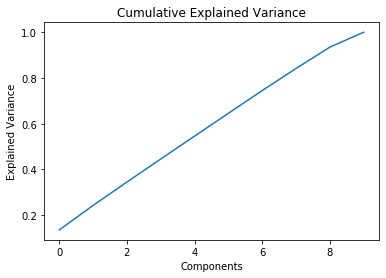

In [8]:
#standardize and transform X
X = df_resampled[['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id', 'add_to_cart_order', 'aisle_id', 'department_id']]
Y = df_resampled['reordered']
X_standard = StandardScaler().fit_transform(X)
pca = PCA().fit(X_standard)
#look at variance explained by PCA components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance')
plt.xlabel('Components')
plt.ylabel('Explained Variance')


In [11]:
#use 9 components in PCA
pca = PCA(n_components=9)
X_PCA = pca.fit_transform(X_standard)
#look at explained variance
pca_variance = pca.explained_variance_ratio_
print('Cumulative Explained Variance: ', pca.explained_variance_ratio_.sum())
print('Percentage of total variance explained by each component:',
    pca.explained_variance_ratio_
)

Cumulative Explained Variance:  0.934792290774152
Percentage of total variance explained by each component: [0.13554423 0.10719643 0.10222855 0.10078741 0.09993766 0.09989265
 0.09936374 0.09654866 0.09329295]


I'll use 9 components, as these 9 components explain approximately 93% of the variance. I'll create a dataframe with these PCA components, split the dataframe into training and test sets, and then train/test each supervised model.

In [12]:
#PCA as a dataframe
PCA_df = pd.DataFrame(X_PCA)
#split data based on PCA
X_train, X_test, y_train, y_test = train_test_split(PCA_df, Y, test_size = 0.2, random_state = 465)

### Logistic Regression with PCA components

In [0]:
#fit a logistic regression
lrm = LogisticRegression()
#grid search to find best parameters
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_lrm_acc = GridSearchCV(lrm, param_grid = grid_values,scoring = 'recall')
grid_lrm_acc.fit(X_train, y_train)

#Predict values based on best parameters
y_pred = grid_lrm_acc.predict(X_test)

In [0]:
#evaluate model
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('AUC Score : ' + str(roc_auc_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Re-order', 'Did Re-order'])
print(report)

cv_scores = cross_val_score(grid_lrm_acc, X_train, y_train, cv = 5)
print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))

print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.6392284060493387
Precision Score : 0.6359167750325098
Recall Score : 0.646612365790448
F1 Score : 0.6412199727263191
AUC Score : 0.6392492789534954
                  precision    recall  f1-score   support

Did Not Re-order       0.64      0.63      0.64     38029
    Did Re-order       0.64      0.65      0.64     37814

        accuracy                           0.64     75843
       macro avg       0.64      0.64      0.64     75843
    weighted avg       0.64      0.64      0.64     75843

Accuracy scores for the 5 folds:  [0.65064725 0.64409236 0.64273009 0.64760524 0.65277686]
Mean cross validation score: 0.648
Confusion Matrix : 
[[24030 13999]
 [13363 24451]]


The logistic regression using the 9 PCA components had a lower accuracy rate than the kBest regression by 3%. 

### KNN with PCA Components

In [0]:
knn = KNeighborsClassifier()
#dictionary with values I want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
#fit model
knn_gscv.fit(X_train, y_train)

#Predict values 
y_pred = knn_gscv.predict(X_test)

In [0]:
#evaluate model
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('AUC Score : ' + str(roc_auc_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Re-order', 'Did Re-order'])
print(report)

cv_scores = cross_val_score(knn_gscv, X_train, y_train, cv = 5)
print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))

print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.7793995490684704
Precision Score : 0.8188692942920234
Recall Score : 0.71589887343312
F1 Score : 0.7639298463448705
AUC Score : 0.7792200459884314
                  precision    recall  f1-score   support

Did Not Re-order       0.75      0.84      0.79     38029
    Did Re-order       0.82      0.72      0.76     37814

        accuracy                           0.78     75843
       macro avg       0.78      0.78      0.78     75843
    weighted avg       0.78      0.78      0.78     75843

Accuracy scores for the 5 folds:  [0.65064725 0.64409236 0.64273009 0.64760524 0.65277686]
Mean cross validation score: 0.648
Confusion Matrix : 
[[32041  5988]
 [10743 27071]]


The KNN model using the PCA components actually improved in accuracy from the Kbest KNN model, with the accuracy rate improving from .75 to .77. This model is slightly concerning though, as the accuracy score is 77% but the accuracy scores for the five folds range from 64-65%, which is a big difference.

### Decision Tree with PCA Components

In [0]:
#fit the tree using the best parameters (determined by gridsearch)
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)
clf.fit(X_train, y_train)
#Predict values 
y_pred = clf.predict(X_test)

In [0]:
#evaluate model
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('AUC Score : ' + str(roc_auc_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Re-order', 'Did Re-order'])
print(report)
cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)
print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))

print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.7634850942077713
Precision Score : 0.8097494078045131
Recall Score : 0.6870471254032898
F1 Score : 0.743368908981659
AUC Score : 0.7632690201157237
                  precision    recall  f1-score   support

Did Not Re-order       0.73      0.84      0.78     38029
    Did Re-order       0.81      0.69      0.74     37814

        accuracy                           0.76     75843
       macro avg       0.77      0.76      0.76     75843
    weighted avg       0.77      0.76      0.76     75843

Accuracy scores for the 5 folds:  [0.73894914 0.73243894 0.73804265 0.7342519  0.73515402]
Mean cross validation score: 0.736
Confusion Matrix : 
[[31925  6104]
 [11834 25980]]


The DT using the 9 PCA components had a decent accuracy at 76% but this is lower than the 80% achieved using the Kbest features.

### Random Forest with PCA Components

In [0]:
#fit the RF using the parameters chosen by gridsearch
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,6,8,10,12,20,40,50,70,90,100]}
clf = GridSearchCV(RandomForestClassifier(), tree_para, cv=5)
clf.fit(X_train, y_train)
#Predict values 
y_pred = clf.predict(X_test)

In [0]:
#see how the model performed
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('AUC Score : ' + str(roc_auc_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Re-order', 'Did Re-order'])
print(report)

cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)
print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.7818203428329944
Precision Score : 0.8333647265649526
Recall Score : 0.7030376863794062
F1 Score : 0.7626736385445247
AUC Score : 0.7816086674923136
                  precision    recall  f1-score   support

Did Not Re-order       0.74      0.86      0.80     37963
    Did Re-order       0.83      0.70      0.76     37759

        accuracy                           0.78     75722
       macro avg       0.79      0.78      0.78     75722
    weighted avg       0.79      0.78      0.78     75722

Accuracy scores for the 5 folds:  [0.7574532  0.75814652 0.75683439 0.7558439  0.75579437]
Mean cross validation score: 0.757
Confusion Matrix : 
[[32655  5308]
 [11213 26546]]


The RF with the PCA components also had a decent accuracy at 78% and does not seem to be overfit. The Kbest RF did have a higher accuracy though, at 83%. 

### SVC with PCA Components

In [0]:
# define parameter range 
param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1,0.01 ,0.001], 
              'kernel': ['rbf']}  
 
#grid search with svc model  
grid_svc = GridSearchCV(SVC(), param_grid, refit = True, verbose = False) 
  
# fit the model for grid search 
grid_svc.fit(X_train, y_train)
#Predict values  
y_pred = grid_svc.predict(X_test)

#see how the model performed
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('AUC Score : ' + str(roc_auc_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Re-order', 'Did Re-order'])
print(report)

cv_scores = cross_val_score(svc, X_train, y_train, cv = 5)
print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.6504318427933757
Precision Score : 0.6670217487794052
Recall Score : 0.5969967424984772
F1 Score : 0.6300695977862872
AUC Score : 0.6502882719420184
                  precision    recall  f1-score   support

Did Not Re-order       0.64      0.70      0.67     37963
    Did Re-order       0.67      0.60      0.63     37759

        accuracy                           0.65     75722
       macro avg       0.65      0.65      0.65     75722
    weighted avg       0.65      0.65      0.65     75722

Accuracy scores for the 5 folds:  [0.65385123 0.65020304 0.65218899 0.65487982 0.65251915]
Mean cross validation score: 0.653
Confusion Matrix : 
[[26710 11253]
 [15217 22542]]


The support vector model using the 9 PCA components did not perform well, at only 65% accuracy. This is interesting because the SV model using the Kbest features performed better. This suggests that using the PCA components made it difficult to separate the data linearly, even in higher dimensions. Given how long the SV classifers are taking to run (~ 3 days), I would recommend against using this model, with or without applying PCA.

### Gradient Boosting with PCA Components

In [53]:
gbc = GradientBoostingClassifier()
#choose parameters to test
parameters = {
    "n_estimators":[5,50,100],
    "max_depth":[1,3,5,7],
    "learning_rate":[0.01,0.1,1]
}
#fit GB model for gridsearch
cv = GridSearchCV(gbc,parameters,cv=5, verbose = False)
cv.fit(X_train, y_train)


#see how the model performed
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('AUC Score : ' + str(roc_auc_score(y_test,y_pred)))
report = classification_report(y_test, y_pred, target_names=['Did Not Re-order', 'Did Re-order'])
print(report)

cv_scores = cross_val_score(cv, X_train, y_train, cv = 5)
print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores)))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.6504450489950081
Precision Score : 0.6466005297875655
Recall Score : 0.6593924627241188
F1 Score : 0.6529338490788698
AUC Score : 0.6504690891446373
                  precision    recall  f1-score   support

Did Not Re-order       0.65      0.64      0.65     37963
    Did Re-order       0.65      0.66      0.65     37759

        accuracy                           0.65     75722
       macro avg       0.65      0.65      0.65     75722
    weighted avg       0.65      0.65      0.65     75722

Accuracy scores for the 5 folds:  [0.65418139 0.64982337 0.65208994 0.65512744 0.65288233]
Mean cross validation score: 0.653
Confusion Matrix : 
[[24355 13608]
 [12861 24898]]


The gradient boosting model using the PCA components also dropped in accuracy in comparison to the Kbest GB model. There is a trend here, with the PCA models having lower accuracy rates than their Kbest counterparts. Of the supervised models, the DTs and RFs predicted the re-orders the best and were consistent across all 5 folds. These algorithms were able to satisfactorily make decisions as to where to split the data and which decision to make at each node. These models also had significantly faster run times, running in a few hours in comparison to 3-4 days with the GB and SV models. Let's see whether we can pull meaningful information about the data using clustering algorithms.

## Unsupervised Learning Models

Unsupervised techniques can be used when the target variable is unknown. These techniques can also be useful even when the target variable is known, as the clusters created can contain meaningful information about the data. I want to cluster the data to determine if I can analyze the clusters to learn something interesting about customers' re-ordering patterns. To draw interesting information from the clusters, I am going to create a few binary variables to later explore the breakdown of those variables across the clusters. Specifically, I'll create a binary variable that measures whether or not the re-ordered product was produce (fruit, vegetable, etc.), a binary variable that distinguishes between high ( > 10 ) and low ( < 10) order numbers, and a variable that captures whether or not the order was placed recently (I consider orders placed less than/equal to 7 days to be "recent"). I'll start by using PCA and UMAP for visualization purposes.

In [37]:
#create binary variables 
df_resampled['fresh'] = (df_resampled['department'] == 'produce').astype(int)
df_resampled['order_often'] = (df_resampled['order_number'] >=10).astype(int)
df_resampled['order_recent'] = (df_resampled['days_since_prior_order']<= 7.0 ).astype(int)

### PCA for Visualization

It can sometimes be useful to apply PCA and use two components to visualize any clustering in the data. I'll apply PCA to the explanatory features (including the binary variables created above) and use 2 components in order to visualize the data in 2D.

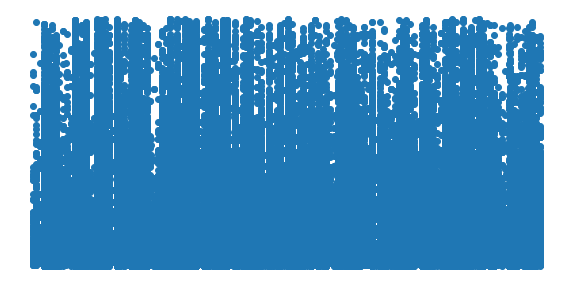

In [0]:
#define X and y 
X = df_resampled[[ 'order_number', 'order_hour_of_day', 'days_since_prior_order',  'add_to_cart_order', 'aisle_id', 'department_id', 'order_recent', 'order_often', 'fresh']]
Y = df_resampled['reordered']

# Use 2 components for two dimensions
pca = PCA(n_components=2)

pca_components = pca.fit_transform(X)
#plot PCA solution
plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

The PCA solution is clearly not helpful in terms of visualizing any clustering in the data. It is not clear at all from the PCA plot as to whether or not the data clusters in meaningful ways. Hopefully UMAP will prove to be more meaningful.

### UMAP for Visualization

UMAP, or Uniform Manifold Approximation and Projection, can be used to represent data in lower dimensions. It is difficult to visualize data in 3, 4, 5, etc. dimensions. UMAP, as with PCA, is a dimension reduction technique. It can be useful to apply UMAP and plot the results when using unsupervised learning to determine how many (if any) clusters there are in the data. I'll tune the parameters a bit to determine if UMAP can be useful here. 

In [0]:
#conda install -c conda-forge umap-learn
import umap
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)

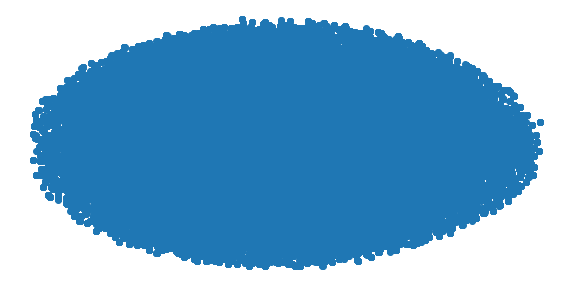

In [0]:
#plot umap results
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [0]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=.001,
                      metric='correlation').fit_transform(X)

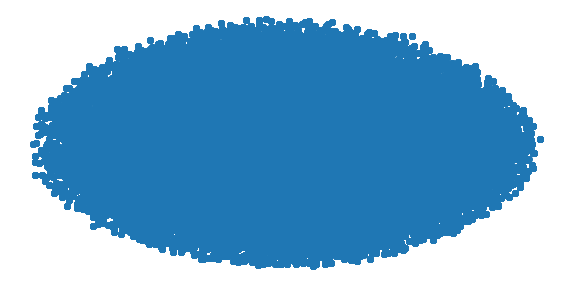

In [0]:
#plot umap results
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

It is not clear from either the PCA or UMAP representations as to how many clusters we need. Therefore, I'll vary the k clusters with K Means and examine their silhouette scores. The silhouette scores are one way to measure similarity; a higher silhouette score (closer to 1) indicates that the datapoints within a cluster are closer to each other than they are to datapoints in other clusters.

### K Means

KMeans is probably the most popular unsupervised clustering technique. This algorithm groups the data points into clusters based on the nearest mean of each cluster. The number of k clusters must be set initially, so there is some trial and error involved in choosing k. K-means does have a few assumptions--that the clusters have equal variance and are radially symmetric. If the clusters are truly not isotropic, this might not be the best algorithm. I'll standard X and fit various k-means models with different k clusters. 

In [0]:
X = df_resampled[[ 'order_number', 'order_hour_of_day', 'days_since_prior_order',  'add_to_cart_order', 'aisle_id', 'department_id', 'order_recent', 'order_often', 'fresh']]
# K mean is sensitive to the scale of data, so we standarize:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
#fit k means and get predictions (3-5 cluster solutions)

pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)
pred_5 = KMeans(n_clusters=5, random_state=123).fit_predict(X_std)

#get silhouette scores for each

print("Silhouette score for three cluster k-means: {}".format(
   metrics.silhouette_score(X_std, pred_3, metric='euclidean')))
print("Silhouette score for four cluster k-means: {}".format(
   metrics.silhouette_score(X_std, pred_4, metric='euclidean')))
print("Silhouette score for five cluster k-means: {}".format(
   metrics.silhouette_score(X_std, pred_5, metric= 'euclidean')))


Silhouette score for three cluster k-means: 0.19208079322172736
Silhouette score for four cluster k-means: 0.17242601667921212
Silhouette score for five cluster k-means: 0.18796097180324742


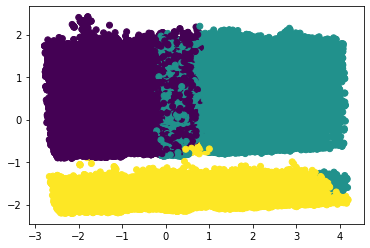

In [0]:
#visualize the k-means 3 cluster solution using 2 PCA components

X_pca = PCA(2).fit_transform(X_std)

# Plot the solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_3)
plt.show()

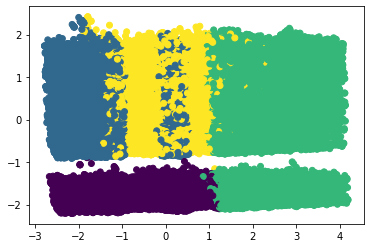

In [0]:
# Plot the 4 cluster solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_4)
plt.show()

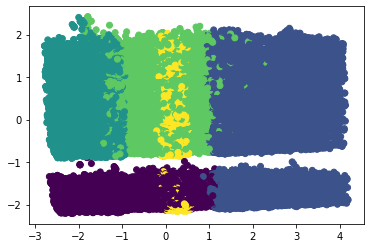

In [0]:
# Plot the 5 cluster solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_5)
plt.show()

The various k-means silhoutte scores are decent, but let's use DBSCAN as well to see if we can improve those silhouette scores.

### Density-based Spatial Clustering of Applications with Noise (DBSCAN)

DBSCAN is a clustering method that is useful for identifying clusters of any shape, unlike K-Means that assumes the clusters to be isotropic. This algorithm divides the datapoints into clusters of highly-dense areas, dense refering to the concentration/closeness of the observations in each cluster. While DBSCAN is useful for identifying non-circular shapes, this algorithm does not perform as well in regard to identifying clusters that are not separated well. We can tune epsilon (the radius to search for nearby observations) and minPts (the minimum number of points necessary to create a cluster) when fitting DBSCAN clustering algorithms. Typically, the number of clusters will decrease as epsilon and minPts decrease. 


In [0]:
dbscan_cluster = DBSCAN(eps=1.5, min_samples=5)

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.1934041779872043


Unfortunately, I faced computational limitations and was unable to run DBSCAN with the epsilon parameter set any higher than 1.5. It would be interesting in the future to run DBSCAN with a larger radius to see if the silhouette score could be improved.

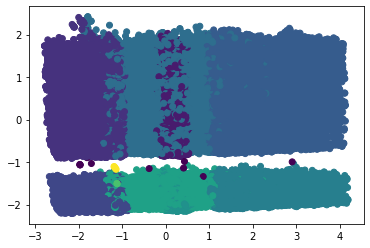

In [0]:
# Plot the solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
plt.show()

### Exploring the Clusters

The silhouette scores are somewhat low, so it might be difficult to learn about this data from clusters. I'll assign labels to the datapoints to further explore the clusters to try and pull meaningful information from them. Since there are only small differences between the silhouette scores for the various k-means clustering solutions, I will look more closely at the K-Means 5 cluster solution to learn more about the data and clusters. I'll also explore the DBSCAN solution.

### K Means 

In [41]:
#K means with 5 clusters
X_std = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [42]:
#add kmeans predictions to X
X['kmeans_fresh'] = kmeans.labels_
X['kmeans_order_often'] = kmeans.labels_
X['kmeans_order_recent'] = kmeans.labels_

Text(0.5, 1.0, 'K-Means Clustering of Fresh Food Re-ordered')

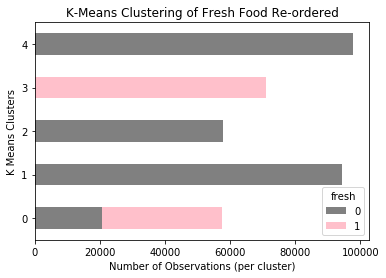

In [43]:
#plot 'fresh' per cluster 
pd.crosstab(X['kmeans_fresh'],df_resampled['fresh']).plot.barh(stacked=True, color =['grey', 'pink'])
plt.ylabel('K Means Clusters')
plt.xlabel('Number of Observations (per cluster)')
plt.title('K-Means Clustering of Fresh Food Re-ordered')



From the above bar plot, we can tell that cluster 3 contains the most re-ordered fresh produce products, while clusters 1, 2, and 4 contain zero fresh products. Cluster 0 is the only cluster that contains both fresh and non-fresh products, though the majority of re-orders in cluster 0 are fresh products. This K-Means solution illustrates that re-orders can certainly be grouped by product type, fresh v. non-fresh in this case.

Text(0.5, 0, 'Number of Observations (per cluster)')

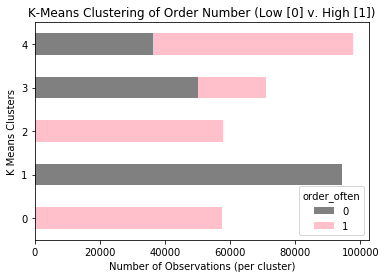

In [44]:
#plot order_often per cluster
pd.crosstab(X['kmeans_order_often'],df_resampled['order_often']).plot.barh(stacked=True,color =['grey', 'pink'] )
plt.ylabel('K Means Clusters')
plt.title('K-Means Clustering of Order Number (Low [0] v. High [1])')
plt.xlabel('Number of Observations (per cluster)')

The above bar plot illustrates that clusters 0 and 2 are comprised entirely of positive values for order_often, which is a binary variable that measures whether the customer has ordered at least 10 times. Cluster 1, on the other hand, is comprised entirely of 0 values for this same binary variable.  Clusters 3 and 4 contain a mix of observations, with cluster 3 having mostly 0 values and cluster 4 having mostly positive values. As with the binary variable for fresh products, this clustering tells me that orders can be grouped together in meaningful ways. Specifically, there is a pattern among the observations indicating that customers who have ordered a lot (at least 10 times) can be grouped together. 

Text(0.5, 0, 'Number of Observations (per cluster)')

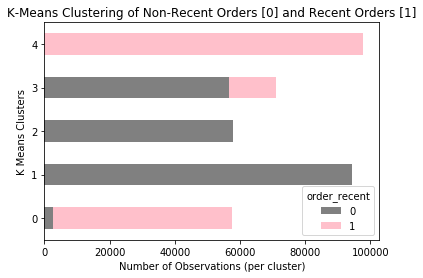

In [45]:
#plot order_recent per cluster
pd.crosstab(X['kmeans_order_recent'],df_resampled['order_recent']).plot.barh(stacked=True, color =['grey', 'pink'])
plt.ylabel('K Means Clusters')
plt.title('K-Means Clustering of Non-Recent Orders [0] and Recent Orders [1]')
plt.xlabel('Number of Observations (per cluster)')

The above bar plot illustrates the breakdown across clusters for the variable order_recent. This is a binary variable that indicates whether or not the order was placed within the last 7 days. The bar plot shows that clusters 0 and 4 contain the highest number of positive observations for the order_recent variable (i.e., 'yes, this order was placed recently'), while clusters 1 and 2 comprise entirely 0 values for order_recent ('this was not a recent order'). Cluster 3 contains a mix of observations, with 0 values for the variable being the majority. All three graphics illustrate that Instacart orders can be distinctively grouped. It would be interesting to further explore this data with clustering in the future to see what else we can learn.

### DBSCAN Clusters

In [0]:
db = DBSCAN(eps=1.5, min_samples=5)
db.fit(X_std)
#add dbscan predictions to X
X['dbscan_fresh'] = db.labels_
X['dbscan_order_often'] = db.labels_
X['dbscan_order_recent'] = db.labels_

Text(0.5, 1.0, 'Fresh Food Re-orders Across DBSCAN Clusters')

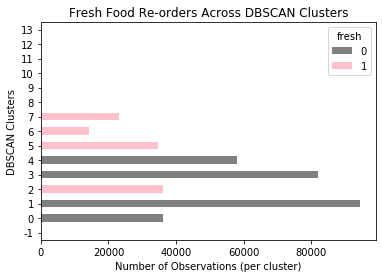

In [0]:
#plot 'fresh' per cluster 
pd.crosstab(X['dbscan_fresh'],df_resampled['fresh']).plot.barh(stacked=True, color =['grey', 'pink'])
plt.ylabel('DBSCAN Clusters')
plt.xlabel('Number of Observations (per cluster)')
plt.title('Fresh Food Re-orders Across DBSCAN Clusters')


Examining the binary variable for fresh food re-orders across the various DBSCAN clusters, it is clear that the re-orders for fresh food can be clearly separated into clusters. Clusters 0, 1, 3, and 4 contain no fresh food re-orders, while the opposite is true for clusters 2 and 5-7.  

Text(0.5, 1.0, 'order_often across DBSCAN Clusters')

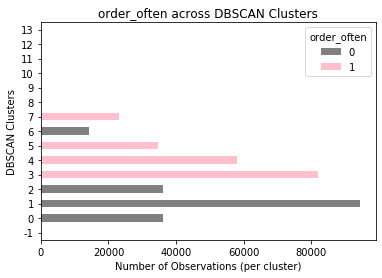

In [0]:
#plot 'orden_often' per cluster 
pd.crosstab(X['dbscan_order_often'],df_resampled['order_often']).plot.barh(stacked=True, color =['grey', 'pink'])
plt.ylabel('DBSCAN Clusters')
plt.xlabel('Number of Observations (per cluster)')
plt.title('order_often across DBSCAN Clusters')

Examining the binary variable for order_often (users who have ordered at least 10 times) across the various DBSCAN clusters, it is clear that these purchases can be clearly separated into clusters. Clusters 0, 1, and 2 contain no observations for order_often, while the opposite is true for clusters 3, 4, 5, and 7.  

Text(0.5, 1.0, 'Recent Orders across DBSCAN Clusters')

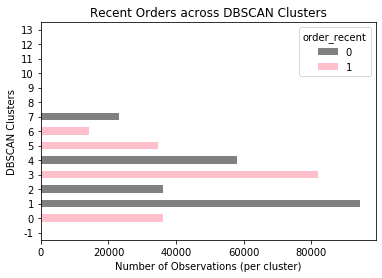

In [0]:
#plot 'order_recent' per cluster 
pd.crosstab(X['dbscan_order_recent'],df_resampled['order_recent']).plot.barh(stacked=True, color =['grey', 'pink'])
plt.ylabel('DBSCAN Clusters')
plt.xlabel('Number of Observations (per cluster)')
plt.title('Recent Orders across DBSCAN Clusters')

Examining the binary variable for recent re-orders across the various DBSCAN clusters, it is clear that the recent re-orders can be clearly separated into clusters. Clusters 1, 2, 4, and 7 contain no recent re-orders, while the opposite is true for clusters 0, 3, 5, and 6. In general, the clustering algorithms are decent in terms of silhouette scores. Plotting the various solutions allows us to see that the data clusters in meaningful ways.  

## Deep Learning (Neural Networks)

Deep learning is powerful and made possible with big data and improved computational resources. Neural networks in particular require stacking layer upon layer when building models. Neural networks consist of an input layer, hidden layer(s), and an outer layer, with each layer having a set number of neurons. The output of one layer becomes the input of the next layer, and so on until the final (outer) layer. The data scientist must decide how many layers and how many neurons per layer when building a neural network. Convolutional Neural Networks (CNNs) are a type of forward-feeding artificial neural network in that the information continues to flow forward through the model. CNNs include various convolutional layers. These models are typically used with images, but I'll try to fit one here because I was only able to achieve a 50% accuracy rate with a basic sequential ANN (this is not included in the capstone because the performance was so incredibly low that I decided to fit a CNN instead). I expect that the CNN won't perform particuarly well since it is best when the target feature is an image or when there are sequential or spatial relationshps between the observations. But let's use keras and tensor flow and fit a CNN to see if it can accurately classify the observations. 

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Convolutional Neural Network

In [16]:
import keras
from keras.models import Sequential, Model
from keras.layers import AveragePooling1D, Dense, Dropout, Flatten, MaxPooling2D, MaxPooling1D, BatchNormalization, Activation, Conv1D, Conv2D 
import tensorflow as tf

Using TensorFlow backend.


In [0]:
#define X and y 
X = df_resampled.drop(['reordered', 'eval_set'], axis = 1).copy()
y = df_resampled['reordered']
#convert string variables to categorical
list_to_categorical = ['department', 'aisle', 'product_name']
for n in list_to_categorical:
    
    X[n] = pd.Categorical(X[n])
    X[n] = X[n].cat.codes
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465)

In [0]:
#standardize X bc ANNs are sensitive to the scale of the data
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [26]:
#preprocess data
# reshape so that a CNN can be fit
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
#get shape to use in CNN
print('X_train shape is:', X_train.shape)
print('X_test shape is:', X_test.shape)

X_train shape is: (302884, 13, 1)
X_test shape is: (75722, 13, 1)


In [0]:
# build model
#2 classes for binary variable
num_classes = 2
#convert X_train to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# convert vectors to matrices for CNN
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [30]:
# Build the model
model = Sequential()
# add convolutional layers
model.add(Conv1D(filters=128, kernel_size=6, activation='relu', input_shape = (13, 1)))
model.add(Conv1D(filters=64, kernel_size=6, activation='relu'))
#include dropout parameter to prevent overfitting
model.add(Dropout(0.5))
model.add(AveragePooling1D(pool_size=3, stride=2, data_format='channels_last', padding='valid',))
model.add(Dropout(0.5))
model.add(Flatten())
#choose neurons and add layers, activation set to 'relu'
model.add(Dense(128, activation='relu', use_bias=False))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(128, activation='relu', use_bias=False))
model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(32, activation='relu', use_bias=False))
model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(16, activation='relu', use_bias=False))
model.add(BatchNormalization())
#final output layer, 2 for binary variable, activation set to softmax, loss to binary_crossentropy
model.add(Dense(num_classes, activation='softmax'))
#compile model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
#fit 
model.fit(X_train, y_train,
          batch_size=128,
          epochs=20,
          verbose=1,
          validation_data=(X_test, y_test))
#get scores and print accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 302884 samples, validate on 75722 samples
Epoch 1/20
302884/302884 [==============================] - 47s 157us/step - loss: 0.6847 - accuracy: 0.5650 - val_loss: 0.6508 - val_accuracy: 0.6308
Epoch 2/20
302884/302884 [==============================] - 46s 152us/step - loss: 0.6489 - accuracy: 0.6327 - val_loss: 0.6253 - val_accuracy: 0.6568
Epoch 3/20
302884/302884 [==============================] - 45s 150us/step - loss: 0.6248 - accuracy: 0.6573 - val_loss: 0.6097 - val_accuracy: 0.6584
Epoch 4/20
302884/302884 [==============================] - 47s 155us/step - loss: 0.6102 - accuracy: 0.6671 - val_loss: 0.5917 - val_accuracy: 0.6808
Epoch 5/20
302884/302884 [==============================] - 45s 149us/step - loss: 0.6027 - accuracy: 0.6712 - val_loss: 0.5931 - val_accuracy: 0.6819
Epoch 6/20
302884/302884 [==============================] - 45s 149us/step - loss: 0.5966 - accuracy: 0.6737 - val_loss: 0.5836 - val_accuracy: 0.6857
Epoch 7/20
302884/302884 [=================

An accuracy rate of 69.5% is clearly not great. While neural networks can be incredibly powerful machine learning algorithms, they are not the best fit for this data. This is likely because the data is not comprised of images and also because there are not sequential relationships between the observations. Also, deep learning is best for extremely large datasets, and this dataset is not particularly large.

### Summary and Suggestions for Instacart

In this project, I explored the data, applied various supervised learning techniques (using both selectKbest and PCA for comparison), used two different clustering algorithms to pull meaningful information from clusters, and attempted to fit a neural network. There are several meaningful take-aways from this analysis. First, it was more useful in terms of prediction accuracy to use Kbest instead of PCA, as the majority of models fit with Kbest features had higher accuracies. However, there is a tradeoff here because the models that were fit with PCA components ran **much** faster (which is logical because PCA is a dimensionality reduction technique). Second, the neural network was not helpful in this case, and CNNs seem to be better fits with data that are images or have sequential relationships between the observations. Third, I would recommend to Instacart that they use either a decision tree or a random forest because these models had accuracy rates between 80-84%, while the logistic regressions had much lower accuracies (~65%). The data does not appear to be linearly separable (at least not in lower dimensions) and thus Instacart should use non-linear classifiers like DTs and RFs to predict re-ordered products.

Instacart can use this analysis and the DT or RF models to predict re-orders and/or for marketing purposes. For instance, knowing that a large number of users order before or at the 7-day mark, Instacart could plan to send out marketing or reminder emails around that time stamp to encourage users to re-order. The data exploration also illustrated that fresh products and organic products are among the most popular re-orders, so Instacart could use that information to send marketing emails that highlight those products in particular. Instacart can also use clustering algorithms to group users in meaningful ways and then target those users in different ways (e.g., they can frequently email the users who order often in comparison to users who do not order often). 

Next steps: In the future, I would like to try and predict which products will be in each order, which will be quite a tall challenge for me. Predicting exactly which products will be in each order will be significantly more challenging than using re-ordered vs. not re-ordered as the target variable. 